In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#import sys
#sys.path.insert(0,"../src/")

from FrankeFunction import FrankeFunction
from linear_regression import *
from bootstrap import *
from cross_validation import *
from stat_tools import *
from main import *
import utils
import unit_tests

utils.plot_settings()

FIGPATH = "../../figs/"

In [2]:
# Make sure things are working as expected
unit_tests.OLS_unit_test()
unit_tests.OLS_SVD_unit_test()
unit_tests.Ridge_unit_test()

## Part a): Ordinary Least Square (OLS) on the Franke function 

- Play around with the franke funtion both with & without noise!
- Perform OLS up to 5th order
- Compute R2
- Compute MSE
- Find confidence interval of beta

In [3]:
# Generate test data
n = 500 # Number of data points

x_dat = np.random.uniform(0, 1, n)
y_dat = np.random.uniform(0, 1, n)
z_dat = FrankeFunction(x_dat, y_dat)

# Set up the scaler
scaler = StandardScaler()

print()

In [4]:


# Wrap the analysis in a function to duplicate for Clean & Noisy data
def p1_analysis(x, y, z, degrees):
    
    mse = pd.DataFrame(columns=["train", "test"], index = degrees)
    r2 = pd.DataFrame(columns=["train", "test"], index = degrees)
    
    # Very hacky way of determining the maximum number of terms of the polynomials
    betas = np.zeros([len(degrees), len(utils.polynomial_form(degrees[-1]))])
    var_betas = np.zeros([len(degrees), len(utils.polynomial_form(degrees[-1]))])

    #var_b = pd.DataFrame(indices=degrees)
    
    for i, deg in enumerate(degrees):
        X = design_matrix(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=False)
        # Normalize data sets
        X_train = scaler.fit_transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.fit_transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])

        beta = OLS_SVD(X_train, z_train)
    
        mse["train"][i] = MSE(z_train, X_train @ beta)
        mse["test"][i] = MSE(z_test, X_test @ beta)
        r2["train"][i] = R2(z_train, X_train @ beta)
        r2["test"][i] = R2(z_test, X_test @ beta)
        
        betas[i, 0:len(beta)] = beta
        var_betas[i, 0:len(beta)] = var_beta(X_train, z_train)

    return mse, r2, betas, var_betas

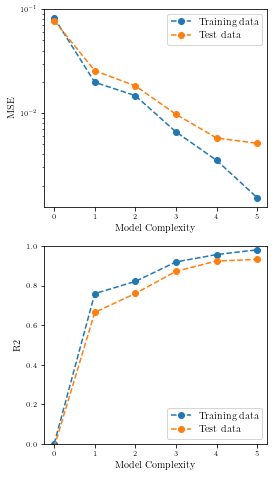

In [24]:
degrees = np.arange(0, 6) # Degrees of the polynom

# Generate data
MSE_clean, R2_clean, betas_clean, var_betas_clean = p1_analysis(x_dat, y_dat, z_dat, degrees)

plt.figure(figsize=(4,8))
plt.tight_layout()
# Plot MSE
plt.subplot(211)
plt.semilogy(degrees, MSE_clean["train"],"o--", label = "Training data")
plt.semilogy(degrees, MSE_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()
# Plot R2
plt.subplot(212)
plt.plot(degrees, R2_clean["train"],"o--", label = "Training data")
plt.plot(degrees, R2_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.ylim([0,1])
plt.legend()

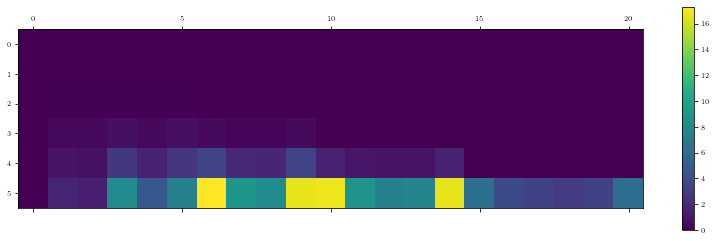

In [33]:
plt.matshow((2 * np.sqrt(var_betas_clean)))
plt.colorbar()

How does the model respond to noise?

[]

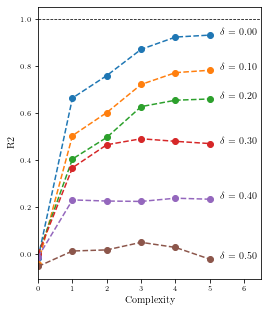

In [6]:
noises = np.linspace(0, .5, 6)
degrees = np.arange(0, 6)

plt.figure(figsize=[4, 5])

for noise in noises:
    # Generate a new noisy dataset
    z_dat_noisy = z_dat + np.random.normal(0, 1, n) * noise
    MSE_noisy, R2_noisy, _, _ = p1_analysis(x_dat, y_dat, z_dat_noisy,degrees)
    
    plt.plot(degrees, R2_noisy["test"], "o--")
    plt.annotate("$\delta=$ %.2f" % noise, [degrees[-1] + .3,R2_noisy["test"].iloc[-1]])

plt.xlim([0, degrees[-1] + 1.5])
plt.axhline([1],color="black", ls="--", lw=0.75)
plt.xlabel("Complexity")
plt.ylabel("R2")
plt.plot()

## Part b): Bias-variance trade-off and resamplng techniques 
- Replicate Fig 2.11 from Hastie et al using bootstrap
- Bias variance analysis

/home/nick/Documents/uni/FYS-STK4155/project_1/src/rewrite/bootstrap.py:8: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "bootstrap" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/nick/Documents/uni/FYS-STK4155/project_1/src/rewrite/bootstrap.py (15)

File "bootstrap.py", line 15:
def bootstrap(X_train, X_test, z_train, z_test, bootstraps, regression):
    <source elided>

    N = z_train.size  # Number of data points in training set
    ^

  @numba.jit
/home/nick/Documents/uni/FYS-STK4155/project_1/src/rewrite/bootstrap.py:8: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "bootstrap" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "bootstrap.py", line 21:
def bootstrap(X_train, X_test, z_train, z_test, bootstraps, regression):
    <source elided>

    for i in range(boots

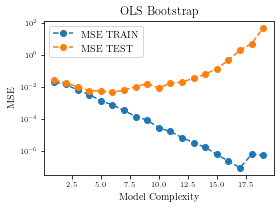

In [7]:
# Reproduce 2.11 in Hastie
degrees = np.arange(1, 20)
N_bootstraps = 300
data_bootstrap = bootstrap_analysis(x_dat, y_dat, z_dat, degrees, N_bootstraps)

plt.figure(figsize=(4,3))
plt.semilogy(degrees, data_bootstrap["MSE train"],"o--", label = "MSE TRAIN")
plt.semilogy(degrees, data_bootstrap["MSE test"],"o--", label = "MSE TEST")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("OLS Bootstrap")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(FIGPATH + "OLS_MSE_Bootstrap_Hastie_211.pdf")

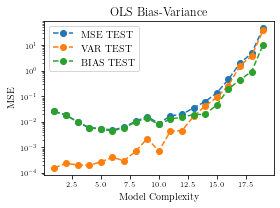

In [8]:
# Bias-Variance Figure

plt.figure(figsize=(4,3))
plt.semilogy(degrees, data_bootstrap["MSE test"],"o--", label = "MSE TEST")
plt.semilogy(degrees, data_bootstrap["Variance test"],"o--", label = "VAR TEST")
plt.semilogy(degrees, data_bootstrap["Bias test"],"o--", label = "BIAS TEST")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("OLS Bias-Variance")
plt.legend(loc="best")
plt.tight_layout()

In [9]:
data_bootstrap

,MSE train,MSE test,R2 test,Bias test,Variance test
1,1.963020e-02,0.025815,0.662210,0.025656,0.000159
2,1.442989e-02,0.018531,0.757522,0.018296,0.000235
3,6.376848e-03,0.010012,0.868996,0.009805,0.000207
4,3.377872e-03,0.005972,0.921852,0.005772,0.000200
5,1.398263e-03,0.005488,0.928190,0.005218,0.000270
6,7.660235e-04,0.004770,0.937583,0.004366,0.000404
7,3.475506e-04,0.006216,0.918661,0.005913,0.000303
8,1.438237e-04,0.010553,0.861907,0.009859,0.000694
9,8.743367e-05,0.016240,0.787497,0.014010,0.002230
10,2.860551e-05,0.008626,0.887123,0.007902,0.000724


## Part c) Cross-validation as resampling techniques, adding more complexity 
- Do cross validation on the dataset. Compare MSE with bootstrap

In [10]:
degrees = np.arange(1, 16)
dat_cross = cv_analysis(x_dat, y_dat, z_dat, degrees, k=5)

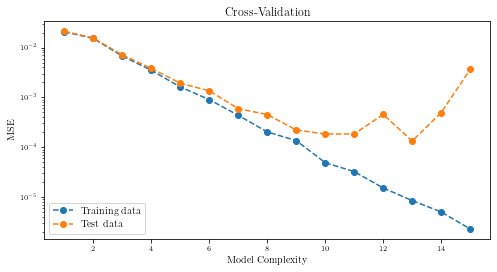

In [11]:
plt.figure(figsize=(8,4))
plt.semilogy(degrees, dat_cross["MSE train"],"o--", label = "Training data")
plt.semilogy(degrees, dat_cross["MSE test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Cross-Validation")
plt.legend(loc="lower left")

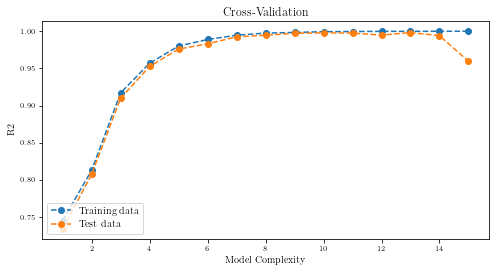

In [12]:
plt.figure(figsize=(8,4))
plt.plot(degrees, dat_cross["R2 train"],"o--", label = "Training data")
plt.plot(degrees, dat_cross["R2 test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.title("Cross-Validation")
plt.legend(loc="lower left")

## Part d): Ridge Regression on the Franke function with resampling 
- Do same analysis, but with Ridge regression

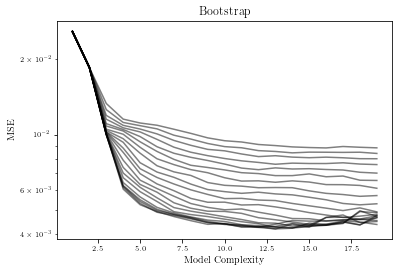

In [15]:
lambdas = np.logspace(-3, 0, 20)

for lamb in lambdas:
    degrees = np.arange(1, 20)
    N_bootstraps = 100
    data_bootstrap = bootstrap_analysis(x_dat, y_dat, z_dat, degrees, N_bootstraps, regression = lambda X, z : linear_regression.Ridge(X, z, lamb = lamb))

    plt.semilogy(degrees, data_bootstrap["MSE test"], label = "MSE TEST", color="black", alpha=0.5)
    #plt.semilogy(degrees, data_bootstrap["Variance test"],"o--", label = "VAR TEST", color="blue")
    #plt.semilogy(degrees, data_bootstrap["Bias test"],"o--", label = "BIAS TEST", color="red")
    plt.xlabel("Model Complexity")
    plt.ylabel("MSE")
    plt.title("Bootstrap")
    #plt.legend(loc="best")

## Part e): Lasso Regression on the Franke function with resampling 
- Do Same analysis, but with Lasso Regression

# Problem 1f)
- Download real data!

# Problem 1d)
= Analyse real data using wisdom gained from Franke Function!

In [14]:
def k_fold_split(X, z, k_folds = 5):
    perm = np.random.permutation(len(z))
    perm = np.split(perm, k_folds)
    return perm

X =  np.ones([5, 5])
z = np.ones([5])
for i in range(5):
    X[i] *= i
    z[i] *= i